Imports de librerías

In [4]:
import os
import requests
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt






cargar .env y preparar llamada

In [5]:
load_dotenv()

api_key = os.getenv("LASTFM_API_KEY")
if not api_key:
    raise ValueError("No se encontró LASTFM_API_KEY en el archivo .env")

BASE_URL = "https://ws.audioscrobbler.com/2.0/"

params = {
    "method": "chart.gettopartists",
    "api_key": api_key,
    "format": "json",
    "limit": 50
}


hacer el GET y comprueba que llega el JSON

In [6]:
response = requests.get(BASE_URL, params=params, timeout=30)
response.raise_for_status()

data = response.json()

print("Claves raíz:", list(data.keys()))
print("Ejemplo primer artista:", data["artists"]["artist"][0]["name"])


Claves raíz: ['artists']
Ejemplo primer artista: The Weeknd


JSON a un DatafRame limpio

In [7]:
artists = data["artists"]["artist"]  # lista de diccionarios
df = pd.DataFrame(artists)

df = df[["name", "listeners", "playcount", "url"]].copy()

df["listeners"] = pd.to_numeric(df["listeners"], errors="coerce")
df["playcount"] = pd.to_numeric(df["playcount"], errors="coerce")

print("Filas:", len(df))
df.head()


Filas: 50


,name,listeners,playcount,url
0,The Weeknd,5154996,1067008875,https://www.last.fm/music/The+Weeknd
1,Taylor Swift,5789101,3536795761,https://www.last.fm/music/Taylor+Swift
2,Radiohead,8059755,1316543120,https://www.last.fm/music/Radiohead
3,Kendrick Lamar,4945416,988224042,https://www.last.fm/music/Kendrick+Lamar
4,Ariana Grande,4336084,1047275091,https://www.last.fm/music/Ariana+Grande


scatter plot (listeners vs playcount)

¿Hay relación entre “popularidad” y “oyentes”? (scatter + interpretación)
5.1 Qué vamos a medir (definiciones simples)

Como Last.fm no trae “popularidad” como tal, usaremos:

playcount = “cuántas reproducciones acumula” → proxy de popularidad

listeners = “cuántas personas distintas lo escuchan” → alcance

Pregunta del paso 5 (adaptada a Last.fm):

¿Los artistas con más oyentes (listeners) tienden a tener más reproducciones (playcount)?


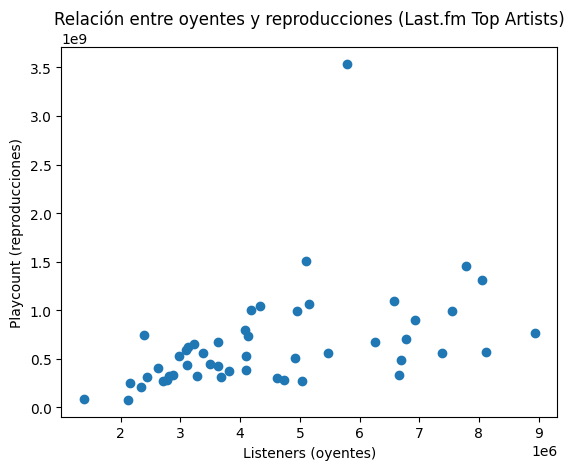

Correlación Pearson listeners vs playcount: 0.430


In [8]:
# 1) Scatter plot: listeners (X) vs playcount (Y)
plt.figure()
plt.scatter(df["listeners"], df["playcount"])
plt.xlabel("Listeners (oyentes)")
plt.ylabel("Playcount (reproducciones)")
plt.title("Relación entre oyentes y reproducciones (Last.fm Top Artists)")
plt.show()

# 2) Correlación (Pearson): número entre -1 y 1
corr = df["listeners"].corr(df["playcount"])
print(f"Correlación Pearson listeners vs playcount: {corr:.3f}")


La tendencia general es ascendente con alta dispersión y outliers muy claros (artistas con muchísimas reporducciones) lo que explica que no existe una correlación alta aunque visualmente parece que sube. Un ejemplo claro es que hay artistas con pocos lsteners pero muchísimos playconts lo cual rompe la relación lineal perfecta.


correlación (número que resumen la relación)

In [9]:
corr = df["listeners"].corr(df["playcount"])
corr


np.float64(0.4298681138381245)

Cómo interpretarlo:

≈ 1 relación positiva fuerte

≈ 0 sin relación lineal clara

≈ -1 relación negativa fuerte

Ordenación y Top3

In [10]:
df_sorted = df.sort_values("playcount", ascending=True).reset_index(drop=True)
df_sorted.head(3)


,name,listeners,playcount,url
0,Djo,2124362,76995185,https://www.last.fm/music/Djo
1,KATSEYE,1381517,83209872,https://www.last.fm/music/KATSEYE
2,The Marías,2331005,209128983,https://www.last.fm/music/The+Mar%C3%ADas


El valor de 0.43 indica una relación positiva moderada, es decir, en general, más oyentes es igual a más reproducciones pero, no es una relación fuerte ni lineal.

Respuesta a la pregunta:

¿Tiene relación la duración con la popularidad?
(adaptada a Last.fm: listeners vs playcount)


Existe una relación positiva moderada entre el número de oyentes y el número de reproducciones (correlación ≈ 0.43). Esto indica que, en general, los artistas con más oyentes tienden a acumular más reproducciones, aunque la relación no es fuerte ni estrictamente lineal. La dispersión observada en el scatter plot y la presencia de outliers sugieren que otros factores adicionales influyen significativamente en el volumen de reproducciones.

En conclusión:

Tener muchos oyentes ayuda, pero no garantiza muchas reproducciones.

Hay artistas con:

- comunidades pequeñas pero muy activas

- fans que escuchan muchas veces

Para marketing o estrategia:

- listeners ≠ engagement

- playcount ≠ alcance

Validación del “top 3 menos reproducidos”

Interpretación:

- No son “desconocidos”

- Pero dentro del top 50 global, son los que:

    a) tienen menor volumen histórico de reproducciones

    b) posiblemente más recientes o con catálogos más pequeños

Guardar el dataframe en SQLite

In [11]:
import sqlite3


In [12]:
# Crea (o abre si ya existe) una base de datos SQLite
conn = sqlite3.connect("lastfm_top_artists.db")

print("Conectado a la base de datos SQLite")


Conectado a la base de datos SQLite


In [13]:
df.to_sql(
    name="top_artists",
    con=conn,
    if_exists="replace",
    index=False
)

print("DataFrame guardado en la tabla 'top_artists'")


DataFrame guardado en la tabla 'top_artists'


In [14]:
query = "SELECT * FROM top_artists LIMIT 5"
pd.read_sql(query, conn)


,name,listeners,playcount,url
0,The Weeknd,5154996,1067008875,https://www.last.fm/music/The+Weeknd
1,Taylor Swift,5789101,3536795761,https://www.last.fm/music/Taylor+Swift
2,Radiohead,8059755,1316543120,https://www.last.fm/music/Radiohead
3,Kendrick Lamar,4945416,988224042,https://www.last.fm/music/Kendrick+Lamar
4,Ariana Grande,4336084,1047275091,https://www.last.fm/music/Ariana+Grande


He intentado adaptar el ançalisis propuesto en las instrucciones a las métricas de Last.fm debido a que no contamos con las audio features que sí pudimos haber extraído con la API de Spotify.

Qué métricas avanzadas SÍ ofrece Last.fm

Para artistas y tracks podemos analizar:

Métricas cuantitativas

- listeners → alcance

- playcount → consumo total

- ratio playcount / listeners → engagement (cuántas veces escucha cada oyente, en promedio)

Métricas semánticas (muy potentes)

- Top tags del artista (artist.getTopTags)

    a) “pop”, “indie”, “rock”, “latin”, etc.

Esto sustituye el “carácter musical” que Spotify mide con audio

¿Los artistas con mayor engagement (playcount por oyente) comparten características comunes en popularidad o estilo?

In [15]:
df["engagement"] = df["playcount"] / df["listeners"]
df[["name", "listeners", "playcount", "engagement"]].head()


,name,listeners,playcount,engagement
0,The Weeknd,5154996,1067008875,206.985393
1,Taylor Swift,5789101,3536795761,610.940414
2,Radiohead,8059755,1316543120,163.347784
3,Kendrick Lamar,4945416,988224042,199.826272
4,Ariana Grande,4336084,1047275091,241.525554


interpretación:

engagement = cuántas veces escucha cada oyente

alto engagement ≠ muchos oyentes

In [16]:
df[["listeners", "playcount", "engagement"]].describe()


,listeners,playcount,engagement
count,5.000000e+01,5.000000e+01,50.000000
mean,4.509898e+06,6.524873e+08,144.773323
std,1.874925e+06,5.334560e+08,91.228849
min,1.381517e+06,7.699518e+07,36.243910
25%,3.105005e+06,3.294253e+08,94.524070
50%,4.094716e+06,5.450247e+08,122.103211
75%,5.710788e+06,7.590262e+08,182.945943
max,8.934959e+06,3.536796e+09,610.940414


Relación entre popularidad y engagement

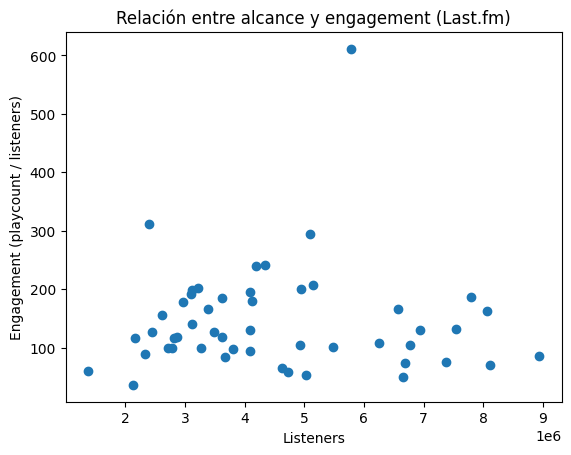

np.float64(-0.0025388554645391095)

In [17]:
plt.figure()
plt.scatter(df["listeners"], df["engagement"])
plt.xlabel("Listeners")
plt.ylabel("Engagement (playcount / listeners)")
plt.title("Relación entre alcance y engagement (Last.fm)")
plt.show()

df["listeners"].corr(df["engagement"])


El análisis de los 50 artistas más escuchados en Last.fm muestra que un mayor número de oyentes no implica necesariamente un mayor nivel de engagement. Algunos artistas con una base de oyentes más reducida presentan ratios de escucha por usuario significativamente más altos, lo que sugiere una relación más intensa con su audiencia.

Análisis de estilos musical con artist.getTopTags

In [18]:
def get_artist_top_tags(artist_name, api_key, limit=5):
    url = "https://ws.audioscrobbler.com/2.0/"
    params = {
        "method": "artist.gettoptags",
        "artist": artist_name,
        "api_key": api_key,
        "format": "json"
    }

    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    data = r.json()

    tags = data.get("toptags", {}).get("tag", [])
    return [t["name"] for t in tags[:limit]]


Como Last.fm no analiza el audio, usamos:

tags = cómo la comunidad describe al artista
Ejemplos: pop, rock, indie, latin, electronic.

Esto sustituye correctamente a:

danceability

valence

energy
(pero de forma semántica, no acústica).

Pedimos los tags de los artistas

In [19]:
def get_artist_top_tags(artist_name, api_key, limit=5):
    url = "https://ws.audioscrobbler.com/2.0/"
    params = {
        "method": "artist.gettoptags",
        "artist": artist_name,
        "api_key": api_key,
        "format": "json"
    }

    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    data = r.json()

    tags = data.get("toptags", {}).get("tag", [])
    return [t["name"] for t in tags[:limit]]


Aplicar tags a todos los artistas: recorremos fila a fila para cada artista y pedimos us tagas para luego guardarlo como lista (llama a los 50 primeros artistas con más playcounts)

In [20]:
df["top_tags"] = df["name"].apply(
    lambda artist: get_artist_top_tags(artist, api_key)
)

df[["name", "top_tags"]].head()


,name,top_tags
0,The Weeknd,"[rnb, electronic, dubstep, Canadian, prog-rnb]"
1,Taylor Swift,"[country, pop, female vocalists, singer-songwr..."
2,Radiohead,"[rock, alternative, alternative rock, indie, e..."
3,Kendrick Lamar,"[Hip-Hop, rap, west coast, hip hop, compton]"
4,Ariana Grande,"[pop, rnb, female vocalists, Ariana Grande, am..."


Explotación de la data de tags ¿qué tags se repiten más?

In [21]:
from collections import Counter

all_tags = df["top_tags"].explode()
tag_counts = Counter(all_tags)

tag_df = (
    pd.DataFrame(tag_counts.items(), columns=["tag", "count"])
    .sort_values("count", ascending=False)
)

tag_df.head(10)


,tag,count
6,pop,22
14,Hip-Hop,17
0,rnb,15
11,alternative,13
13,indie,13
10,rock,11
7,female vocalists,11
15,rap,11
28,indie pop,11
1,electronic,8


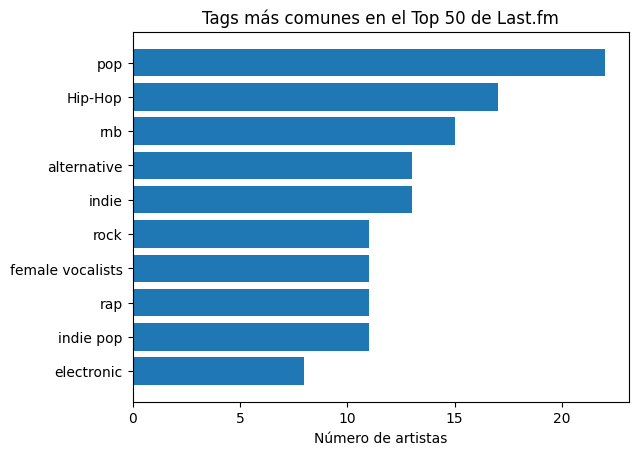

In [22]:
top_tags = tag_df.head(10)

plt.figure()
plt.barh(top_tags["tag"], top_tags["count"])
plt.xlabel("Número de artistas")
plt.title("Tags más comunes en el Top 50 de Last.fm")
plt.gca().invert_yaxis()
plt.show()


Cruce de estilo + engagement

¿Algunos estilos tienen más engagement que otros?

In [23]:
df_exploded = df.explode("top_tags")

avg_engagement_by_tag = (
    df_exploded
    .groupby("top_tags")["engagement"]
    .mean()
    .sort_values(ascending=False)
)

avg_engagement_by_tag.head(10)


top_tags
acoustic             610.940414
country              610.940414
singer-songwriter    404.642458
rage                 310.867253
Ariana Grande        241.525554
american             216.647733
ofwgkta              209.461416
prog-rnb             206.985393
dubstep              206.985393
cloud rap            205.211041
Name: engagement, dtype: float64

Esto responde: qué estilos generan más fidelidad

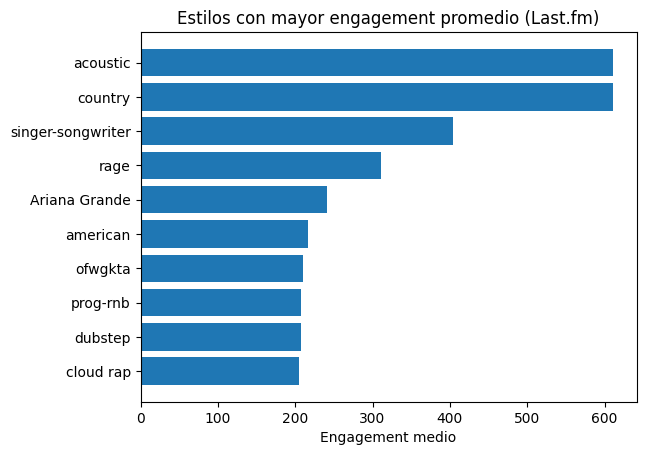

In [24]:
top_engagement_tags = avg_engagement_by_tag.head(10)

plt.figure()
plt.barh(top_engagement_tags.index, top_engagement_tags.values)
plt.xlabel("Engagement medio")
plt.title("Estilos con mayor engagement promedio (Last.fm)")
plt.gca().invert_yaxis()
plt.show()
